In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import sys
sys.path.append('../../../optimal-signal-demixing/')
from osd import Problem
from osd.components import (
    MeanSquareSmall, 
    TimeSmoothEntryClose, 
    TimeSmoothPeriodicEntryClose,
    LinearTrend
)
from osd.components.wrappers import make_columns_equal

In [36]:
T = 100
p = 5
period = 17

lambda1 = 20
lambda2 = 8
weight = 1
rho = 1 
vavg = None
np.random.seed(42)
v_in = np.random.randn(T, p)
tsec = TimeSmoothEntryClose(lambda1=lambda1, lambda2=lambda2, vavg=vavg, period=period)
v_out = tsec.prox_op(v_in, weight, rho)

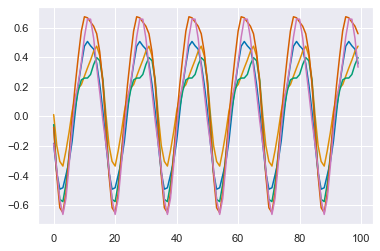

In [37]:
plt.plot(10 * v_out)

In [38]:
np.savetxt('vector_smooth_periodic_low_var.txt', 10 * v_out)

In [39]:
X1 = 0.15 * np.random.randn(T, p)
X2 = 10 * v_out
X3 = np.tile(np.linspace(0, 2, T), (p, 1)).T
X_real = np.array([X1, X2, X3])
y = np.sum(X_real, axis=0)

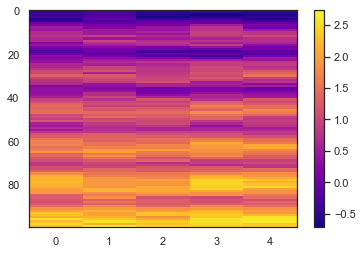

In [40]:
with sns.axes_style('white'):
    plt.imshow(y, aspect='auto', interpolation='none', cmap='plasma')
    plt.colorbar()
    plt.show()

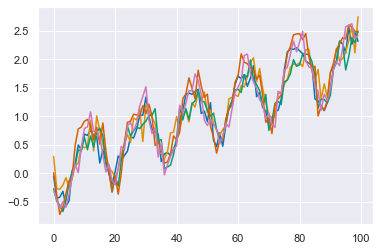

In [41]:
plt.plot(y)

In [153]:
def make_data():
    data_file_path = "vector_smooth_periodic_low_var.txt"
    with open(data_file_path) as file:
        data = np.loadtxt(file)
    T, p = data.shape
    np.random.seed(110100100)
    X1 = 0.15 * np.random.randn(T, p)
    X2 = data
    X3 = np.tile(np.linspace(0, 2, T), (p, 1)).T
    X_real = np.array([X1, X2, X3])
    y = np.sum(X_real, axis=0)
    use_set = np.random.uniform(size=v_in.shape) >= 0.25
    use_set[40:50] = False
    y[~use_set] = np.nan
    return y, X_real

def make_data2():
    data_file_path = "vector_smooth_periodic_low_var.txt"
    with open(data_file_path) as file:
        data = np.loadtxt(file)
    T, p = data.shape
    np.random.seed(110100100)
    X1 = 0.15 * np.random.randn(T, p)
    X2 = data
    X_real = np.array([X1, X2])
    y = np.sum(X_real, axis=0)
    use_set = np.random.uniform(size=v_in.shape) >= 0.25
    use_set[40:50] = False
    y[~use_set] = np.nan
    return y, X_real

In [43]:
import cvxpy as cvx
rms = lambda x: np.sqrt(np.average(np.power(x, 2)))

# Using general smooth class with additional constraints

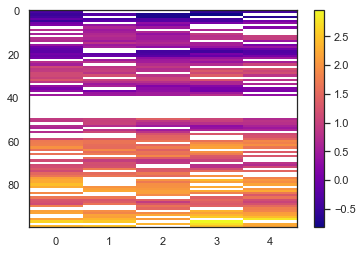

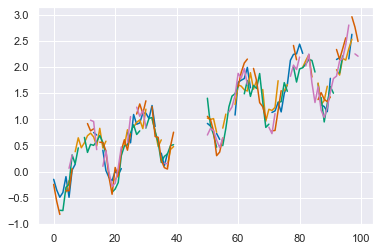

In [218]:
y, X_real = make_data()
with sns.axes_style('white'):
    plt.imshow(y, aspect='auto', interpolation='none', cmap='plasma')
    plt.colorbar()
    plt.show()
plt.plot(y);
plt.show()

In [219]:
components = [
    MeanSquareSmall(size=y.size),
    TimeSmoothEntryClose(
        lambda1=1e2, lambda2=1e-2, weight=5e-3/y.size, period=period
    ),
    make_columns_equal(LinearTrend)(first_val=0),
]
problem = Problem(y, components=components)

In [220]:
problem.decompose(how='cvx', reset=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jan 27 04:48:46 PM: Your problem has 1600 variables, 5 constraints, and 3 parameters.
(CVXPY) Jan 27 04:48:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 27 04:48:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 27 04:48:46 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jan 27 04:48:46 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jan 27 04:48:46 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 27 04:48:46 PM: Applying reduction Qp2SymbolicQ

In [221]:
problem.objective_value

0.01676289724409303

In [222]:
problem.problem.value

0.016762897244096898

In [223]:
rms(problem.estimates[0] - X_real[0])

0.09068211467331277

In [224]:
rms(problem.estimates[1] - X_real[1])

0.05295818311360539

In [225]:
rms(problem.estimates[2] - X_real[2])

0.024533027887939877

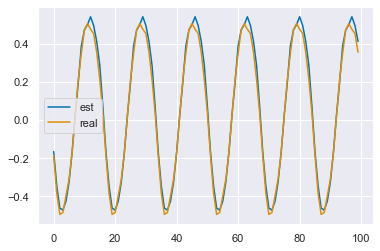

In [226]:
col = 0
comp = 1
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

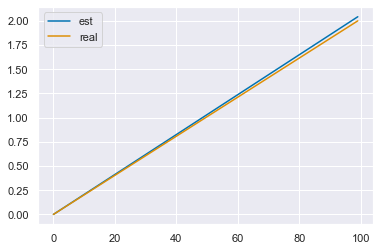

In [227]:
# col = 3
comp = 2
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

In [228]:
problem.decompose(how='admm', reset=True, stop_early=False)

[====================] ...79 iterations, 0.33 sec -- obj_val: 1.68e-02, r: 7.58e-06, tol: 1.01e-05      



In [229]:
problem.objective_value

0.01676291010882617

In [230]:
rms(problem.estimates[0] - X_real[0])

0.0906677314668865

In [231]:
rms(problem.estimates[1] - X_real[1])

0.0529567518881385

In [232]:
rms(problem.estimates[2] - X_real[2])

0.024390416261782125

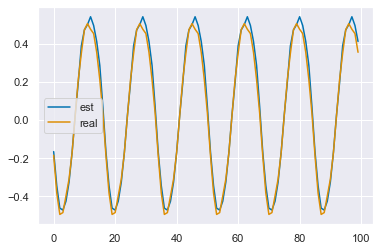

In [233]:
col = 0
comp = 1
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

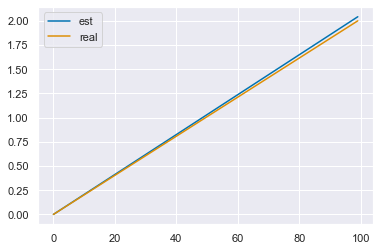

In [234]:
# col = 3
comp = 2
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

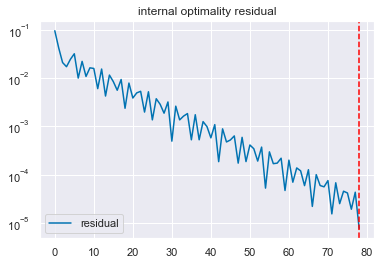

In [235]:
plt.figure()
plt.plot(problem.admm_result['optimality_residual'], label='residual')
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.legend()
plt.title('internal optimality residual')
plt.show()

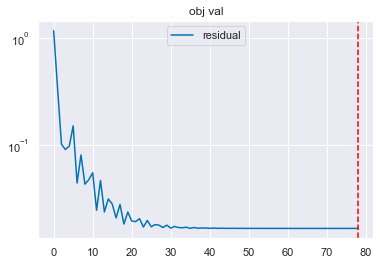

In [236]:
plt.figure()
plt.plot(problem.admm_result['obj_vals'], label='residual')
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.legend()
plt.title('obj val')
plt.yscale('log')
plt.show()

In [237]:
problem.decompose(how='bcd', reset=True)

Starting BCD...
y shape: (100, 5)
X shape: (3, 100, 5)

[====================] ...26 iterations, 0.10 sec -- obj_val: 1.68e-02, r: 7.82e-06, tol: 1.01e-05      



In [238]:
problem.objective_value

0.016765020589367758

In [239]:
rms(problem.estimates[0] - X_real[0])

0.09086995141158444

In [240]:
rms(problem.estimates[1] - X_real[1])

0.05372202812473581

In [241]:
rms(problem.estimates[2] - X_real[2])

0.027937901626655326

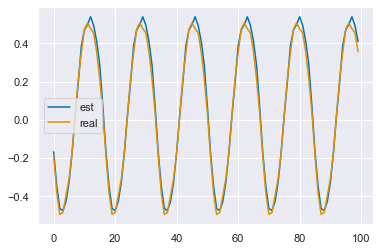

In [242]:
col = 0
comp = 1
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

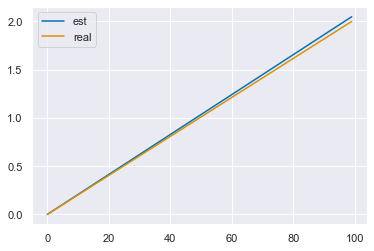

In [243]:
# col = 3
comp = 2
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

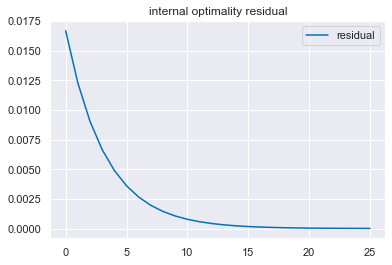

In [244]:

plt.figure()
plt.plot(problem.bcd_result['optimality_residual'], label='residual')
plt.legend()
plt.title('internal optimality residual')
plt.show()

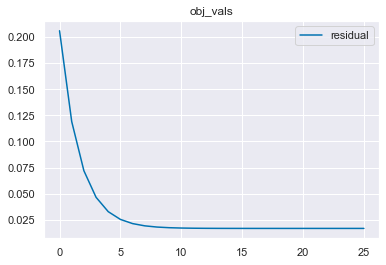

In [245]:
plt.figure()
plt.plot(problem.bcd_result['obj_vals'], label='residual')
plt.legend()
plt.title('obj_vals')
plt.show()

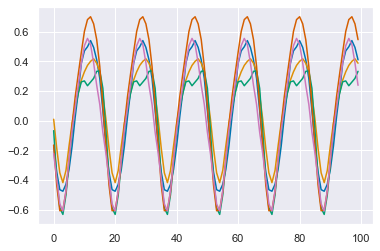

In [246]:
plt.plot(problem.estimates[1])

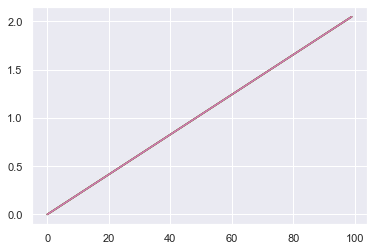

In [247]:
plt.plot(problem.estimates[2])

## Prox op check

In [248]:
w = .1
r = 2

y, X_real = make_data2()

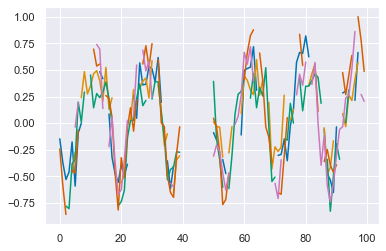

In [249]:
plt.plot(y)

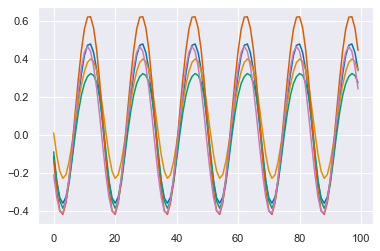

In [250]:
use_set = ~np.isnan(y)

prox_op = problem.components[1].prox_op
v_prox = prox_op(y, w, r, use_set=use_set)
plt.plot(v_prox)

In [251]:
use_set = ~np.isnan(y)
import cvxpy as cvx
x = cvx.Variable((T, p))
cost = w * problem.components[1].cost(x) + (r / 2) * cvx.sum_squares(x[use_set] - y[use_set])
constraints = [x[:-period] == x[period:]]
cvx_prox_op = cvx.Problem(cvx.Minimize(cost), constraints)

In [252]:
cvx_prox_op.solve()

20.044749891835373

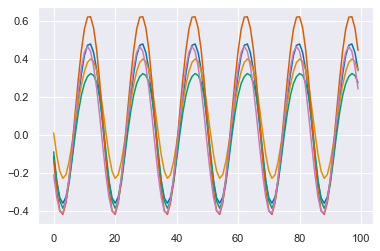

In [253]:
plt.plot(x.value)

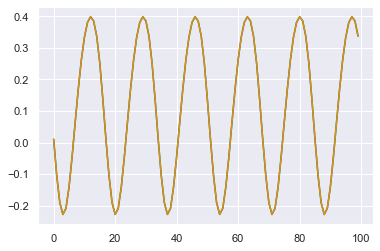

In [254]:
col = 1
plt.plot(v_prox[:, col])
plt.plot(x.value[:, col]);

# Using periodic subclass with smaller matrices

In [455]:
y, X_real = make_data()

In [456]:
components = [
    MeanSquareSmall(size=y.size),
    TimeSmoothPeriodicEntryClose(
        lambda1=1e2, lambda2=1e-2, weight=5e-3/y.size, period=period
    ),
    make_columns_equal(LinearTrend)(first_val=0),
]
problem = Problem(y, components=components)

In [457]:
problem.decompose(how='cvx', reset=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jan 27 09:21:27 PM: Your problem has 1517 variables, 5 constraints, and 3 parameters.
(CVXPY) Jan 27 09:21:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 27 09:21:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 27 09:21:27 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jan 27 09:21:27 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jan 27 09:21:27 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 27 09:21:27 PM: Applying reduction Qp2SymbolicQ

In [458]:
problem.objective_value

0.016678053421649224

In [459]:
problem.problem.value

0.016678053421649224

In [460]:
rms(problem.estimates[0] - X_real[0])

0.09069355721443387

In [461]:
rms(problem.estimates[1] - X_real[1])

0.05301377017190441

In [462]:
rms(problem.estimates[2] - X_real[2])

0.02465684203047785

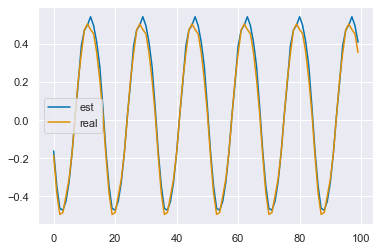

In [463]:
col = 0
comp = 1
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

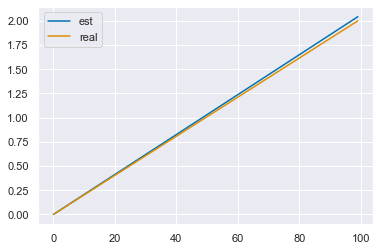

In [464]:
# col = 3
comp = 2
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

In [465]:
problem.decompose(how='admm', reset=True, stop_early=False)

[====================] ...79 iterations, 0.34 sec -- obj_val: 1.67e-02, r: 7.65e-06, tol: 1.01e-05      



In [466]:
problem.objective_value

0.016680346995303044

In [467]:
rms(problem.estimates[0] - X_real[0])

0.0906962571716549

In [468]:
rms(problem.estimates[1] - X_real[1])

0.05301769411423296

In [469]:
rms(problem.estimates[2] - X_real[2])

0.024493093447236658

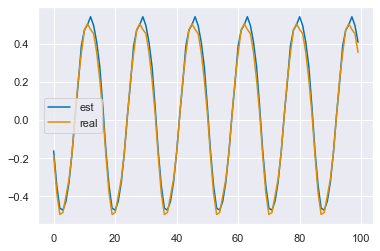

In [470]:
col = 0
comp = 1
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

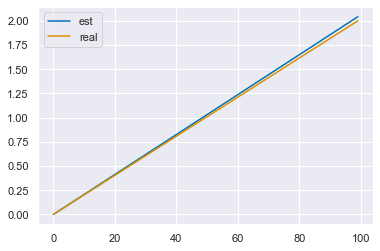

In [471]:
# col = 3
comp = 2
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

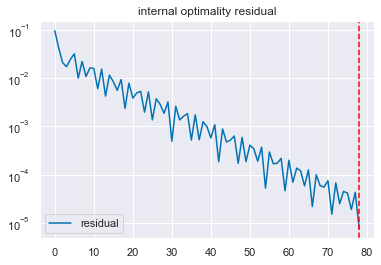

In [472]:
plt.figure()
plt.plot(problem.admm_result['optimality_residual'], label='residual')
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.legend()
plt.title('internal optimality residual')
plt.show()

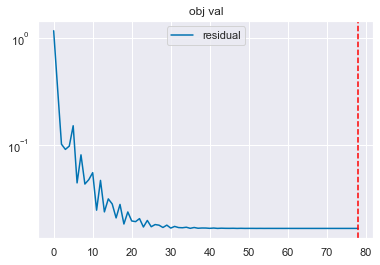

In [473]:
plt.figure()
plt.plot(problem.admm_result['obj_vals'], label='residual')
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.legend()
plt.title('obj val')
plt.yscale('log')
plt.show()

In [474]:
problem.decompose(how='bcd', reset=True)

Starting BCD...
y shape: (100, 5)
X shape: (3, 100, 5)

[====================] ...26 iterations, 0.12 sec -- obj_val: 1.67e-02, r: 7.79e-06, tol: 1.01e-05      



In [475]:
problem.objective_value

0.016682382817549964

In [476]:
rms(problem.estimates[0] - X_real[0])

0.09089679069283227

In [477]:
rms(problem.estimates[1] - X_real[1])

0.053779657079446125

In [478]:
rms(problem.estimates[2] - X_real[2])

0.02800430072373432

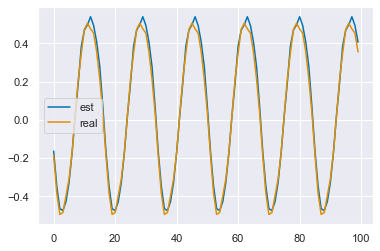

In [479]:
col = 0
comp = 1
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

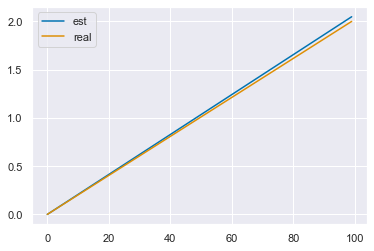

In [480]:
# col = 3
comp = 2
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

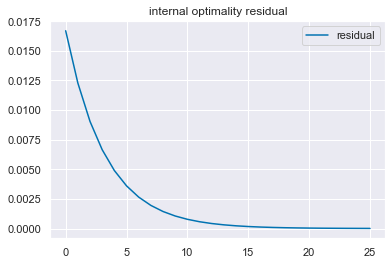

In [481]:

plt.figure()
plt.plot(problem.bcd_result['optimality_residual'], label='residual')
plt.legend()
plt.title('internal optimality residual')
plt.show()

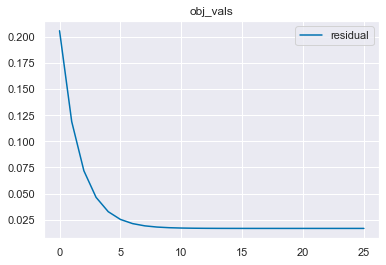

In [482]:
plt.figure()
plt.plot(problem.bcd_result['obj_vals'], label='residual')
plt.legend()
# plt.yscale('log')
plt.title('obj_vals')
plt.show()

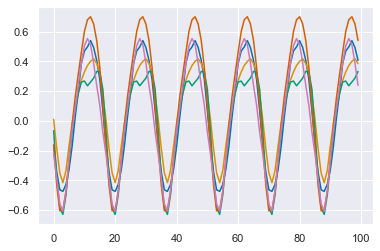

In [483]:
plt.plot(problem.estimates[1])

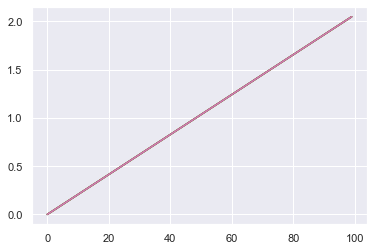

In [484]:
plt.plot(problem.estimates[2])

## Prox op check

In [485]:
w = .1
r = 2

y, X_real = make_data2()

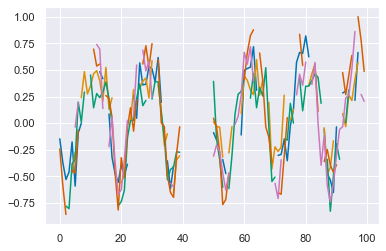

In [486]:
plt.plot(y)

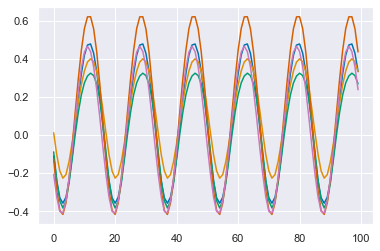

In [487]:
use_set = ~np.isnan(y)

prox_op = problem.components[1].prox_op
v_prox = prox_op(y, w, r, use_set=use_set)
plt.plot(v_prox)

In [488]:
use_set = ~np.isnan(y)
import cvxpy as cvx
x = cvx.Variable((T, p))
cost = w * problem.components[1].cost(x) + (r / 2) * cvx.sum_squares(x[use_set] - y[use_set])
constraints = [x[:-period] == x[period:]]
cvx_prox_op = cvx.Problem(cvx.Minimize(cost), constraints)

In [489]:
cvx_prox_op.solve()

19.639961237878865

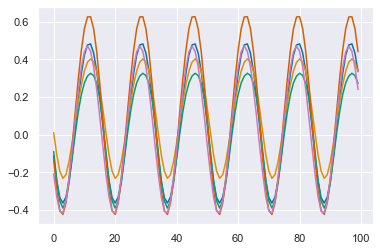

In [490]:
plt.plot(x.value)

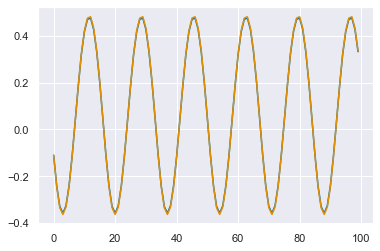

In [492]:
col = 0
plt.plot(v_prox[:, col])
plt.plot(x.value[:, col]);